In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


2023-06-06 15:13:21.666946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
import ast
import matplotlib.pyplot as plt
import scipy.signal as signal
from wfdb import processing
from scipy.fftpack import fft, ifft 

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    meta_data = data[0][1]
    return data, meta_data


In [5]:
sampling_rate=100
path='/'

Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [6]:
X, meta_data = load_raw_data(Y, sampling_rate, path)

In [ ]:
record = wfdb.rdrecord(Y.filename_lr.iloc[0])
display(wfdb.plot_wfdb(record=record, title=f'ECG_id {Y.index[1]}'))

In [7]:
print(X.shape)
print(X[0].T.shape)
print(X[0].T.shape[1])

(21799, 1000, 12)
(12, 1000)
1000


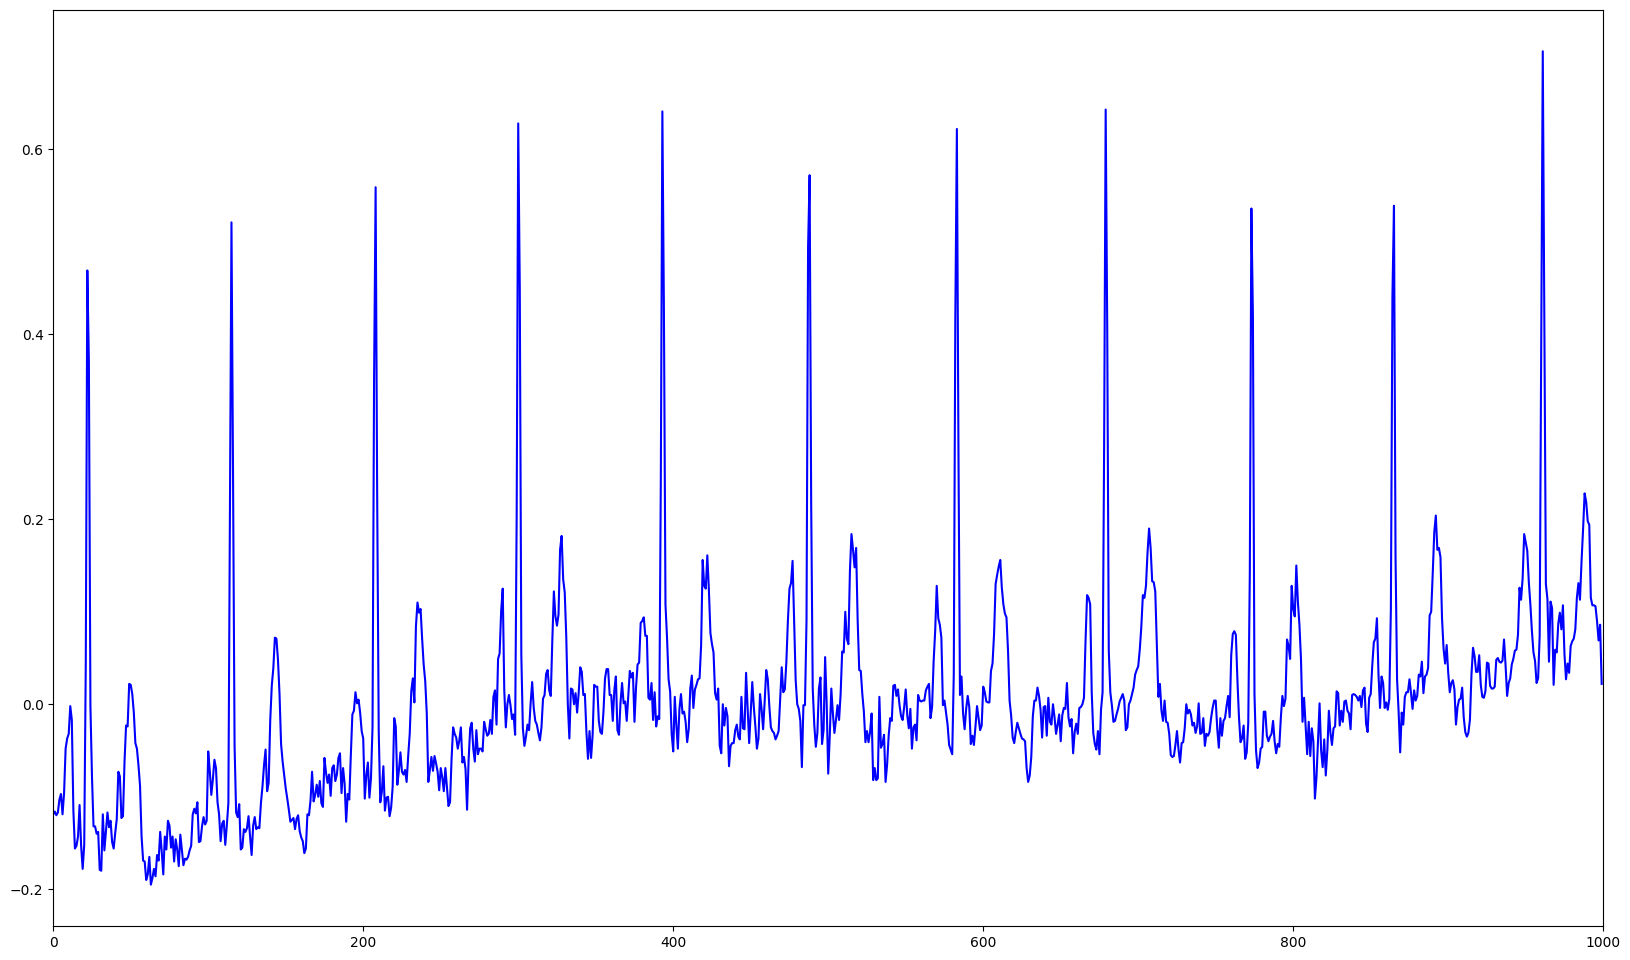

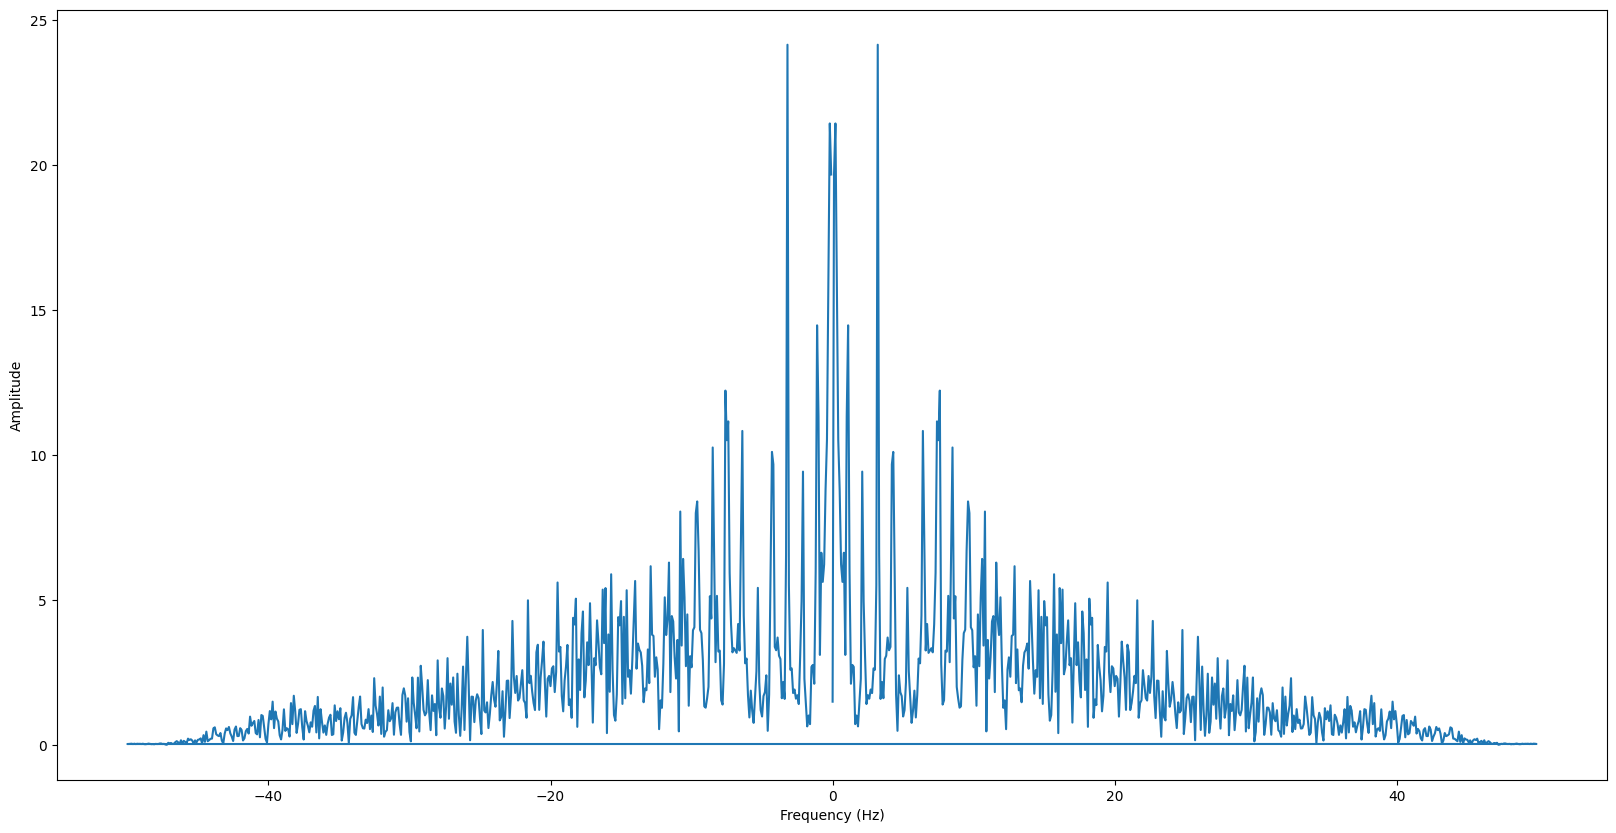

In [8]:
fig = plt.figure(figsize=(20, 50))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot((X[0].T)[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)

# Frequency Domain

ecg_spectrum = np.fft.fft(X[0].T[0][:])
freq = np.fft.fftfreq(X[0].T.shape[1], d=0.01)

# Plot frequency spectrum
plt.figure(figsize=(20,10))
plt.plot(freq, np.abs(ecg_spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()


PRE-PROCESSING STEP

In [ ]:
def ecg_fft_ana(ecg_original, sampling_rate):
    fs = 100
    ts = 1.0/fs
    t = np.arange(0, 1, ts)
    n = len(ecg_original)
    k = np.arange(n)
    t = n/fs
    frq = k/t
    frq = frq[range(int(n/2))]
    fft_ecg = np.abs(fft(ecg_original))[range(int(n/2))]
    return frq, fft_ecg



def show_spec_dif(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    frq, fft_ecg = ecg_fft_ana(ecg_original, sampling_rate)
    frq_filtered, fft_ecg_filtered = ecg_fft_ana(ecg_filtered, sampling_rate)
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.plot(ecg_original[:500])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(frq,fft_ecg)
    plt.title(title1 + '`s spectrum')
    plt.subplot(223)
    plt.plot(ecg_filtered[:500])
    plt.title(title2)
    plt.subplot(224)
    plt.plot(frq_filtered, fft_ecg_filtered)
    plt.title(title2 + '`s spectrum')
    plt.show()

show_spec_dif(X[0].T[0][:], filtered_data[0][0], 'original ecg signal', 'final filtered')

baseline wander removal = low-frequency drift

In [12]:
import scipy.signal as signal
baseline_removed_ecg = np.zeros((21799, 12, 1000))

for sig in range(X.shape[0]):
    for lead in range(X.shape[2]):
        

        nyquist_freq = 0.5 * 100
        cutoff_freq = 0.5 
        filter_order = 4

        # Design a Butterworth highpass filter
        b, a = signal.butter(filter_order, cutoff_freq / nyquist_freq, btype='highpass')

        # Apply the filter to the ECG signal
        baseline_removed_ecg[sig][lead] = signal.filtfilt(b, a, X[sig].T[lead][:])

In [13]:
baseline_removed_ecg.shape

(21799, 12, 1000)

In [ ]:
fig = plt.figure(figsize=(20, 50))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(X[0].T[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)

# Frequency Domain

ecg_spectrum = np.fft.fft(filtered_data[0][0][:])
freq = np.fft.fftfreq(baseline_removed_ecg[0].shape[1], d=1/100)

# Plot frequency spectrum
plt.figure(figsize=(20,10))
plt.plot(freq, np.abs(ecg_spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your filtered data is stored in a variable called "filtered_data"
signal = X[0].T[0][:]

# Calculate the Fourier transform of the signal
signal_spectrum = np.fft.fft(signal)

# Calculate the frequency axis for the spectrum
freq_axis = np.fft.fftfreq(len(signal), d=1/100)

# Plot the frequency spectrum
plt.plot(freq_axis, np.abs(signal_spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

# Find the maximum frequency present in the signal
max_freq = np.max(freq_axis[np.abs(signal_spectrum) > 0.1*np.max(np.abs(signal_spectrum))])
print("Maximum frequency present in the signal: {:.2f} Hz".format(max_freq))


Text(0.5, 1.0, 'baseline filtered ECG')

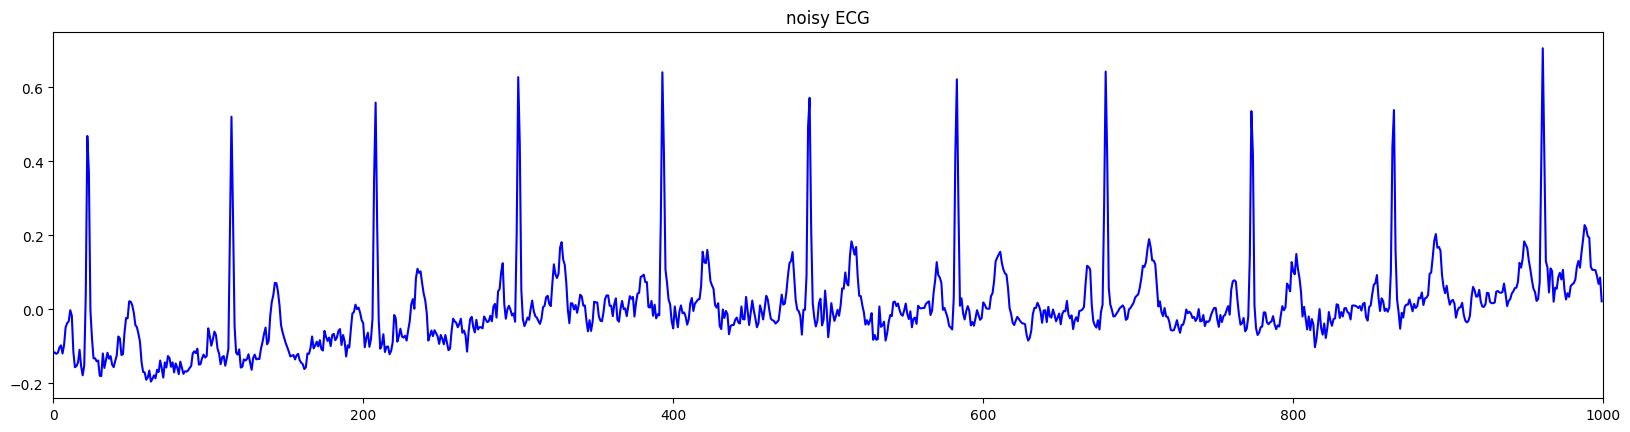

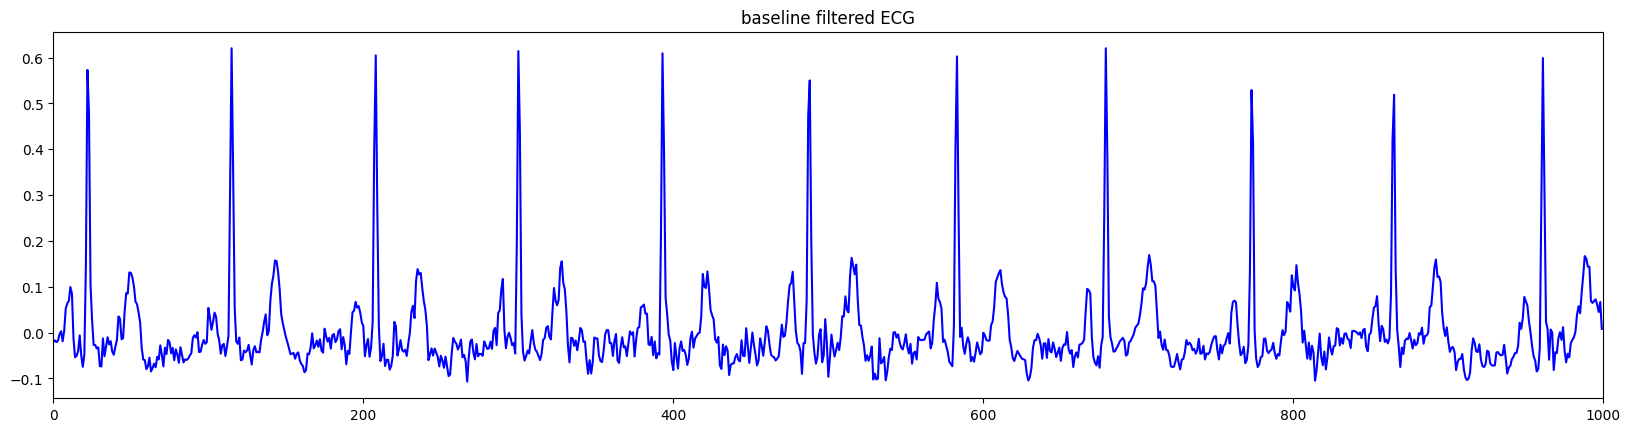

In [14]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot((X[0].T)[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('noisy ECG')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(baseline_removed_ecg[0][0], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('baseline filtered ECG')

In [12]:
# np.save('highpass_filtered.npy', filtered_data)

In [12]:
loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')

In [7]:
loaded_highpassedfiltered_signal.shape

(21799, 12, 1000)

In [ ]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(X[0].T[11][:], color = 'blue')
arr_signal.set_xlim(0, 1000)

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(filtered_data[0][11], color = 'blue')
arr_signal.set_xlim(0, 1000)

band pass filter

In [48]:
from scipy import signal
filtered_data_newversion_3 = np.zeros((21799, 12, 1000))

# for sig in range(X.shape[0]):
#     for lead in range(X.shape[2]):

lowcut = 0.5  
highcut = 20 
order = 4  
nyquist_freq = 0.5 * 100
low = lowcut / nyquist_freq
high = highcut / nyquist_freq
b, a = signal.butter(order, [low, high], btype='band')

filtered = signal.filtfilt(b, a, X[0].T[0][:])

Text(0.5, 1.0, 'bandpass filtered signal')

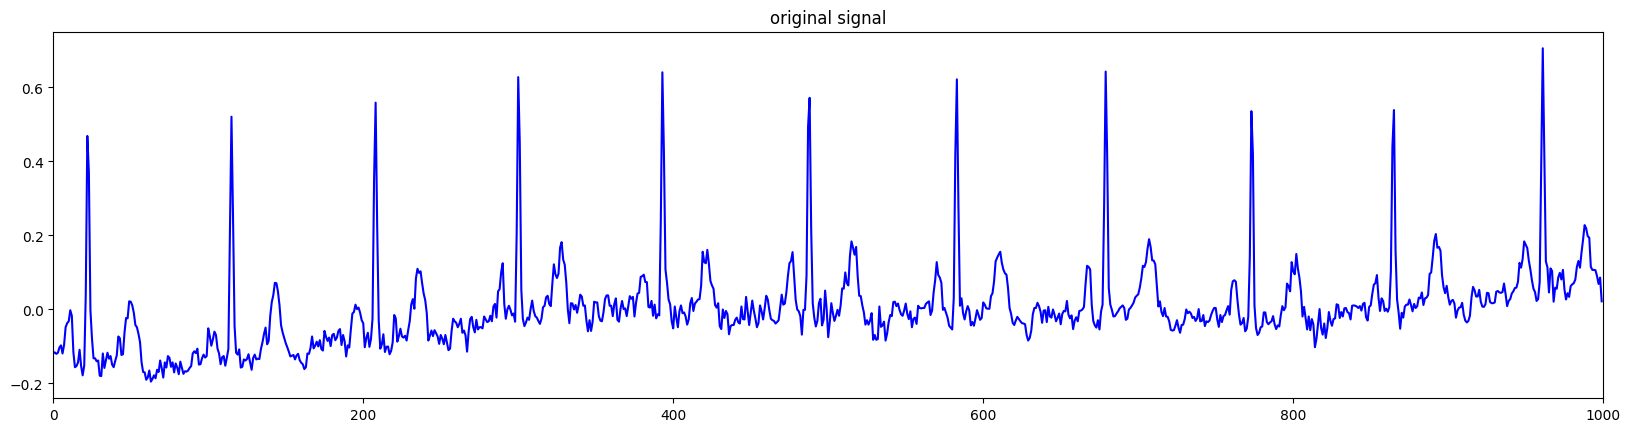

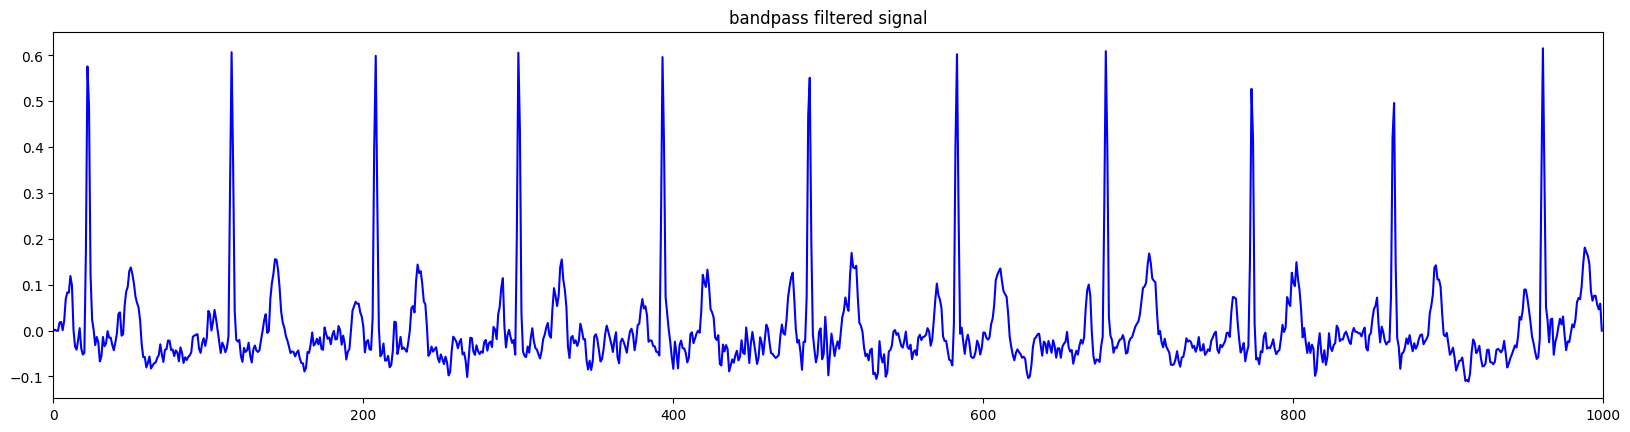

In [26]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(X[0].T[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('original signal')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(filtered, color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('bandpass filtered signal')

In [19]:
import scipy.signal as signal
Highpassesfiltered_data_version2 = np.zeros((21799, 12, 1000))

for sig in range(filtered_data_newversion.shape[0]):
    for lead in range(filtered_data_newversion.shape[1]):
        
        nyquist_freq = 0.5 * 100
        cutoff_freq = 0.5 
        filter_order = 4

        # Design a Butterworth highpass filter
        b, a = signal.butter(filter_order, cutoff_freq / nyquist_freq, btype='highpass')

        # Apply the filter to the ECG signal
        Highpassesfiltered_data_version2[sig][lead] = signal.filtfilt(b, a, filtered_data_newversion[sig][lead][:])


Moving Average Filter

In [38]:
MovingAvarage_filtered = np.zeros((21799, 12, 1000))
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

# for sig in range(Highpassesfiltered_data_version2.shape[0]):
#     for lead in range(Highpassesfiltered_data_version2.shape[1]):
MovingAvarage_filtered = np_move_avg(filtered, 3)


Text(0.5, 1.0, 'moving average filtered signal')

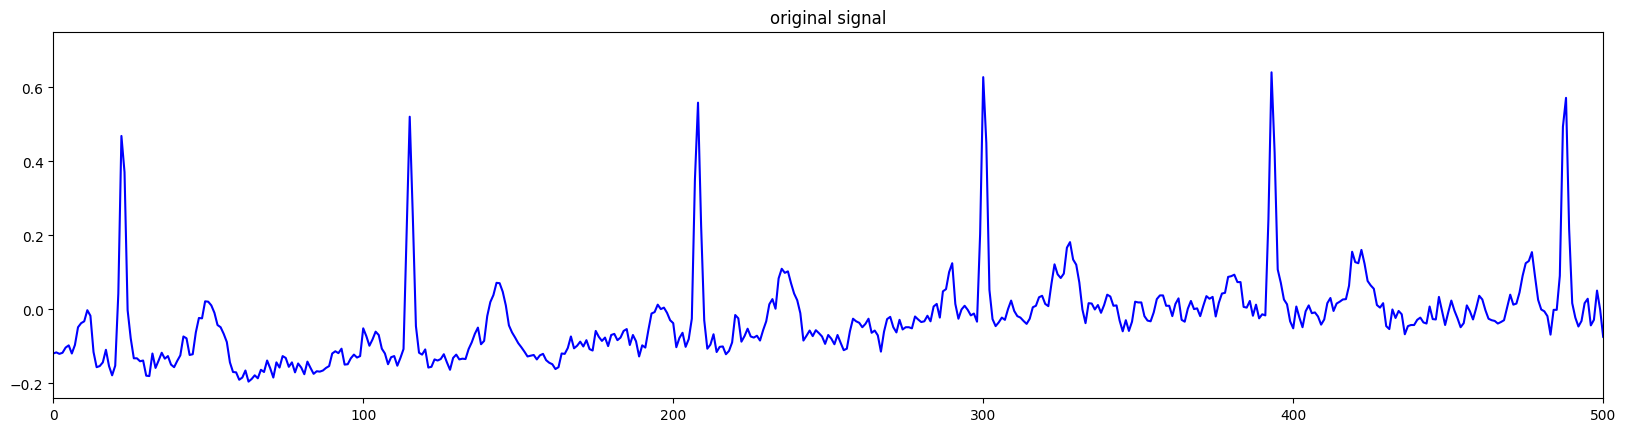

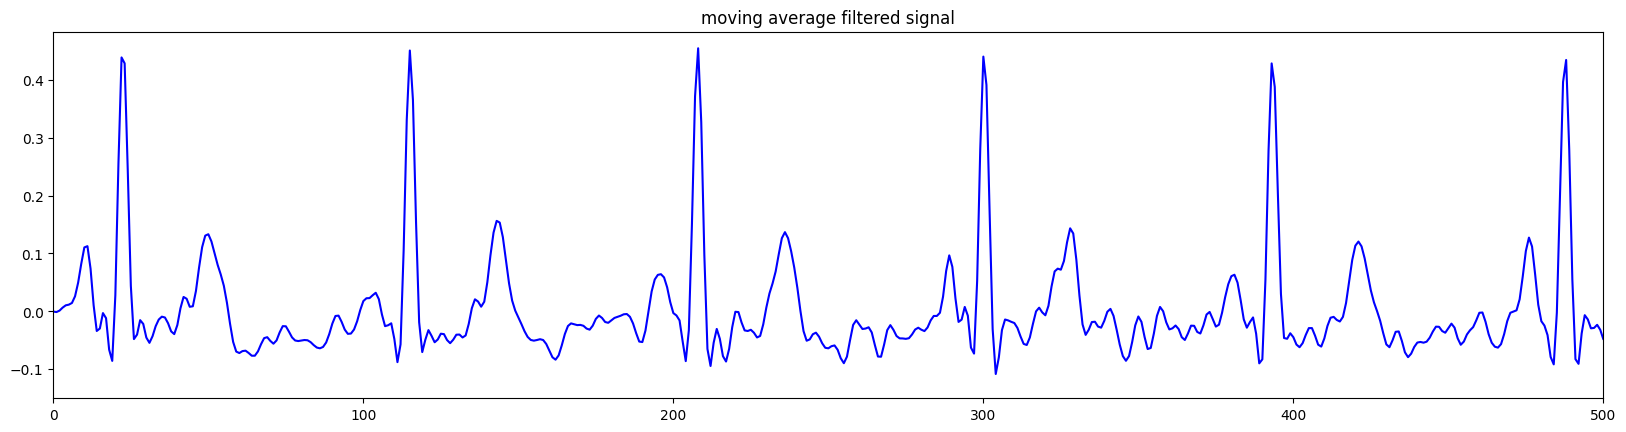

In [49]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(X[0].T[0][:], color = 'blue')
arr_signal.set_xlim(0, 500)
plt.title('original signal')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(filtered, color = 'blue')
arr_signal.set_xlim(0, 500)
plt.title('moving average filtered signal')

# fig = plt.figure(figsize=(20, 20))
# grid = plt.GridSpec(3, 1, hspace=0.6)
# arr_signal = fig.add_subplot(grid[0, 0])
# arr_signal.plot(filtered_data_newversion[0][0], color = 'blue')
# arr_signal.set_xlim(0, 1000)
# plt.title('bandpass filtered signal')

# fig = plt.figure(figsize=(20, 20))
# grid = plt.GridSpec(3, 1, hspace=0.6)
# arr_signal = fig.add_subplot(grid[0, 0])
# arr_signal.plot(Highpassesfiltered_data_version2[0][0], color = 'blue')
# arr_signal.set_xlim(0, 1000)
# plt.title('bandpass filtered signal version 2')

# fig = plt.figure(figsize=(20, 20))
# grid = plt.GridSpec(3, 1, hspace=0.6)
# arr_signal = fig.add_subplot(grid[0, 0])
# arr_signal.plot(MovingAvarage_filtered[0][0], color = 'blue')
# arr_signal.set_xlim(0, 1000)
# plt.title('mving average filtered signal')

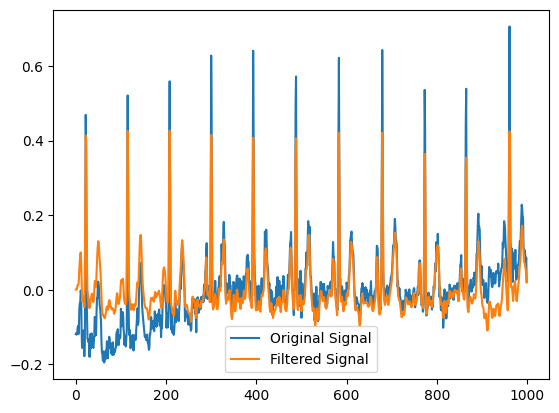

In [44]:
import numpy as np
import matplotlib.pyplot as plt



# Define the filter kernel (in this case, a moving average filter)
window_size = 3
kernel = np.ones(window_size) / window_size

# Apply the filter to the data
y_filtered = np.convolve(filtered, kernel, mode='same')

# Plot the results
plt.plot(X[0].T[0][:], label='Original Signal')
plt.plot(y_filtered, label='Filtered Signal')
plt.legend()
plt.show()


FEATURE EXTRACTION STEP

R-R interval

In [ ]:
# Extract R-peak locations using a peak detection algorithm
r_peaks, _ = wfdb.processing.gqrs_detect(X[0].T[0][:])

# Convert R-peak locations to time stamps
r_times = wfdb.rpeak2time(r_peaks, 100)

# Compute R-R intervals
rr_intervals = np.diff(r_times)

print(rr_intervals)

TRAIN 

In [15]:
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
# agg_df.head()

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y.diagnostic_superclass.to_csv('diagnostic_superclass', index=None)

In [16]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass